# Time series forecasting

# Initial setup

## Import required packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [2]:
data = pd.read_csv('../data/airline-passenger-traffic+(1).csv', header = None)
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


# Time series analysis

## Plot time series data

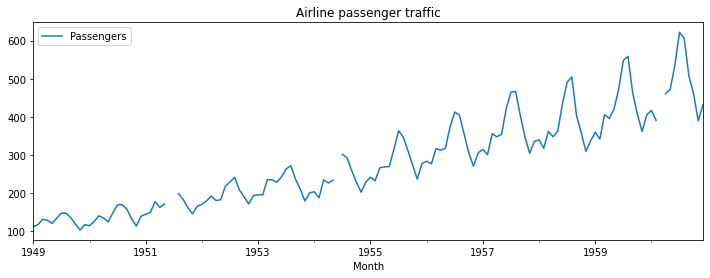

In [3]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

## Missing value treatment

### Mean imputation

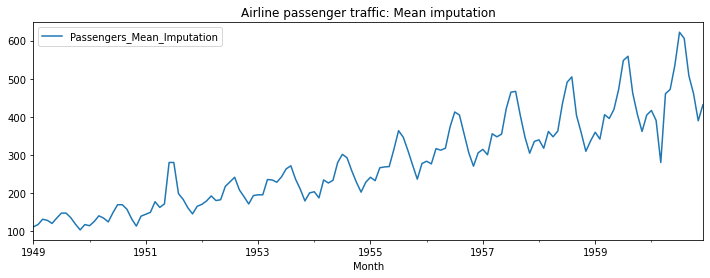

In [4]:
data = data.assign(Passengers_Mean_Imputation=data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Mean imputation')
plt.show(block=False)

### Linear interpolation

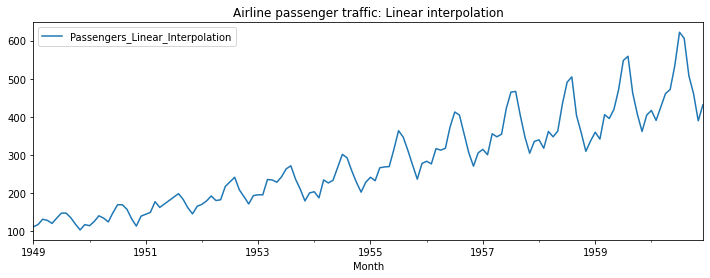

In [5]:
data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Linear interpolation')
plt.show(block=False)

### Use linear interpolation to impute missing values

In [6]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)

## Outlier detection

### Box plot and interquartile range

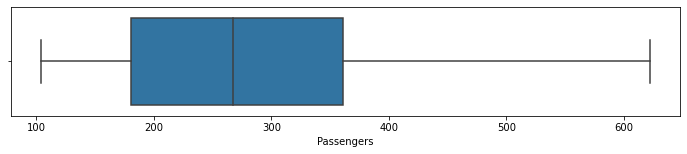

In [7]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Passengers'],whis=1.5)

### Histogram plot

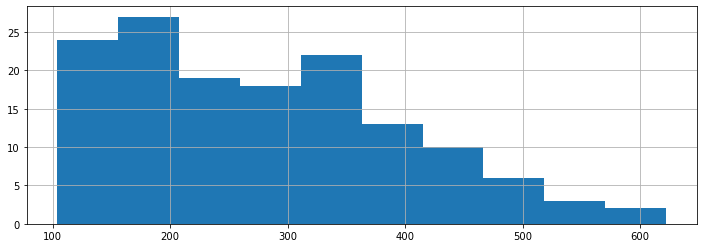

In [8]:
fig = data.Passengers.hist(figsize = (12,4))

## Time series Decomposition

### Additive seasonal decomposition

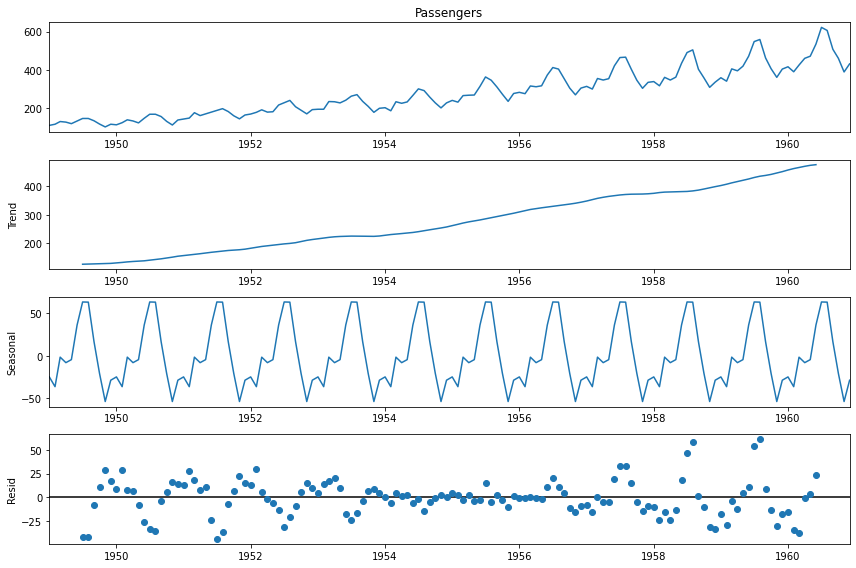

In [9]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### Multiplicative seasonal decomposition

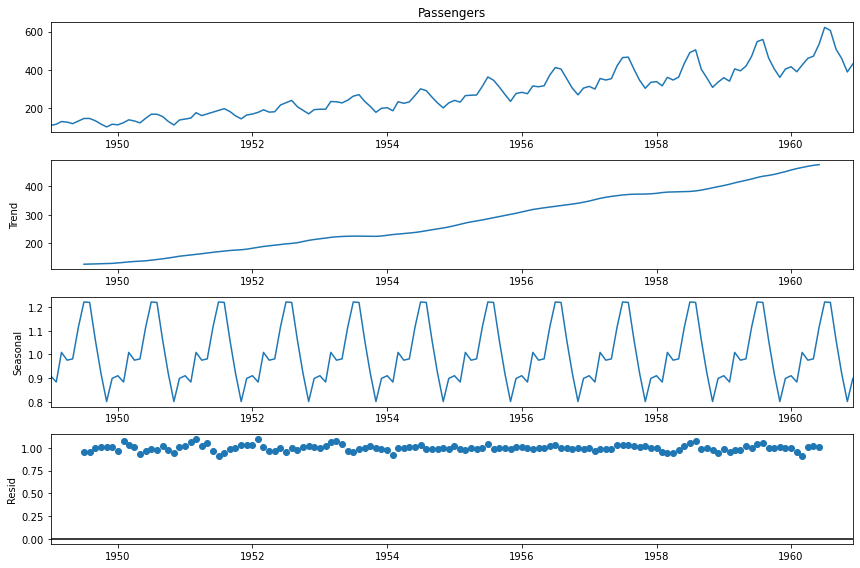

In [10]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

# Build and evaluate time series forecast

## Split time series data into training and test set

In [11]:
train_len = 120
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

# Simple time series methods

## Naive method

In [12]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

### Plot train, test and forecast

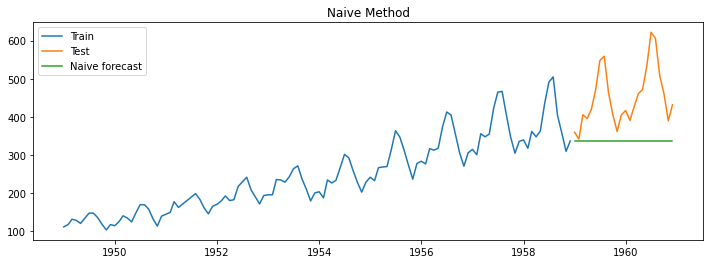

In [13]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [14]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63


## Simple average method

In [15]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

### Plot train, test and forecast

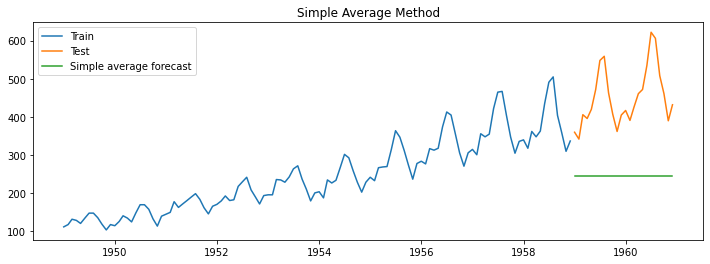

In [16]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

### Calculate RMSE and MAPE

In [17]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28


## Simple moving average method

In [18]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

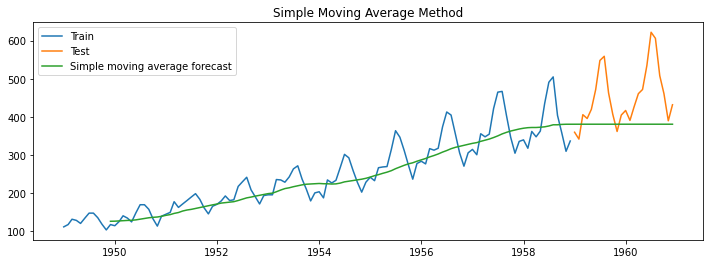

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [20]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54


# Exponential smoothing methods

## Simple exponential smoothing

In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Plot train, test and forecast

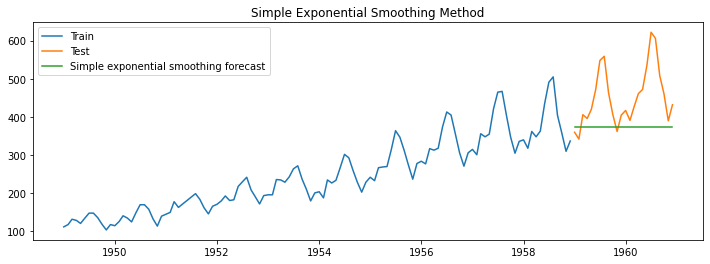

In [22]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [23]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49


## Holt's method with trend

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

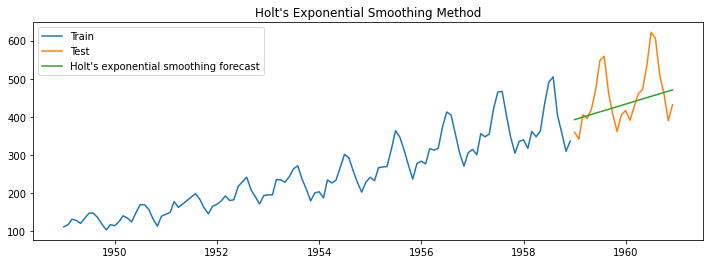

In [25]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [26]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11


## Holt Winters' additive method with trend and seasonality

In [27]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.23615815135772011, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.7638418486422799, 'damping_trend': nan, 'initial_level': 204.98775010890893, 'initial_trend': 2.277125578879114, 'initial_seasons': array([ -95.26477839,  -89.72946402,  -77.22895316,  -82.34755114,
        -91.04048136,  -76.87513463,  -64.61027726,  -66.56007629,
        -80.69101219,  -99.57005515, -114.23801844,  -98.02808547]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

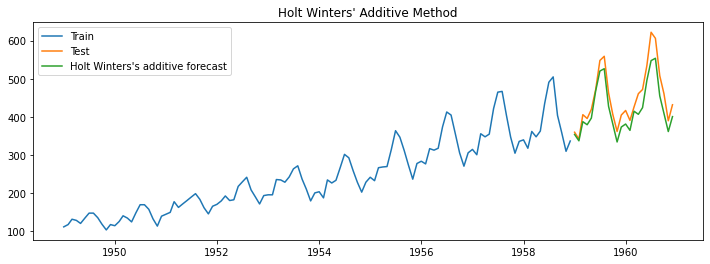

In [28]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [29]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.86,6.72


## Holt Winter's multiplicative method with trend and seasonality

In [30]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.3655865614456789, 'smoothing_trend': 8.003382780364158e-08, 'smoothing_seasonal': 0.6344134168549864, 'damping_trend': nan, 'initial_level': 182.90595507171616, 'initial_trend': 3.9608579040286487, 'initial_seasons': array([0.59936353, 0.63043657, 0.69295765, 0.65877107, 0.60804705,
       0.664941  , 0.72308922, 0.71817668, 0.65513481, 0.57089973,
       0.50755226, 0.58555887]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

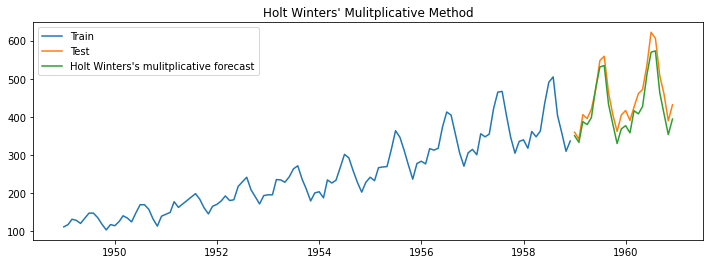

In [31]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

### Calculate RMSE and MAPE

In [32]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.86,6.72
0,Holt Winters' multiplicative method,32.46,6.45


# Auto Regressive methods

## Stationarity vs non-stationary time series

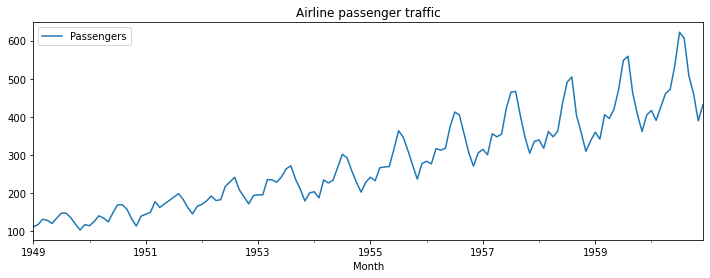

In [33]:
data['Passengers'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

### Augmented Dickey-Fuller (ADF) test

In [34]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: 0.894609
Critical Values @ 0.05: -2.88
p-value: 0.993020


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [35]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Passengers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.052050
Critical Values @ 0.05: 0.46
p-value: 0.010000


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


### Box Cox transformation to make variance constant

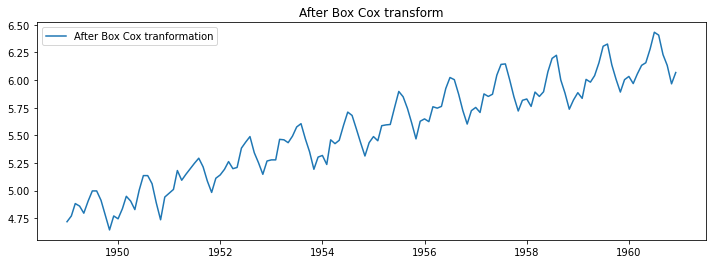

In [36]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

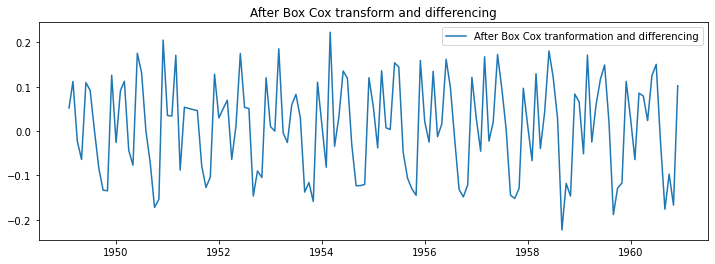

In [37]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [38]:
data_boxcox_diff.dropna(inplace=True)

In [39]:
data_boxcox_diff.tail()

Month
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
dtype: float64

### Augmented Dickey-Fuller (ADF) test

In [40]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.290114
Critical Values @ 0.05: -2.88
p-value: 0.015326


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [41]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.101871
Critical Values @ 0.05: 0.46
p-value: 0.100000


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


## Autocorrelation function (ACF)

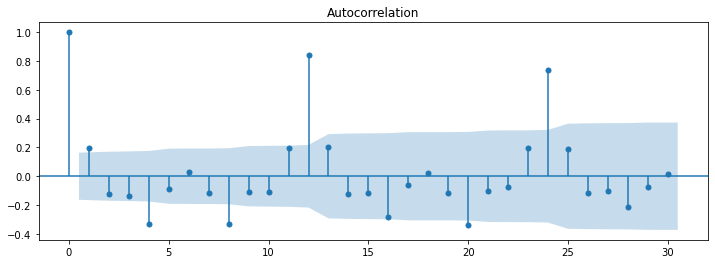

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

## Partial autocorrelation function (PACF)

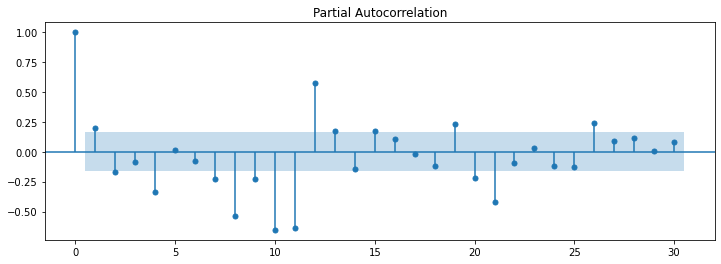

In [43]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [44]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [45]:
train_data_boxcox_diff

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
                ...   
1958-08-01    0.028114
1958-09-01   -0.223144
1958-10-01   -0.118092
1958-11-01   -0.146750
1958-12-01    0.083511
Length: 119, dtype: float64

## Auto regression method (AR)

In [46]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.009477
ar.L1.y    0.183116
dtype: float64


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Recover original time series

In [47]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train, test and forecast

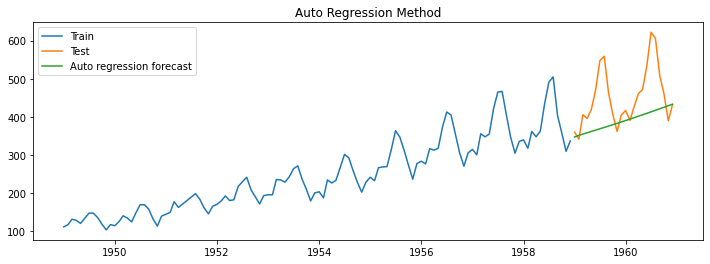

In [48]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [49]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ar['ar_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.86,6.72
0,Holt Winters' multiplicative method,32.46,6.45
0,Autoregressive (AR) method,93.39,13.77


## Moving average method (MA)

In [50]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.009538
ma.L1.y    0.266103
dtype: float64


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Recover original time series

In [51]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

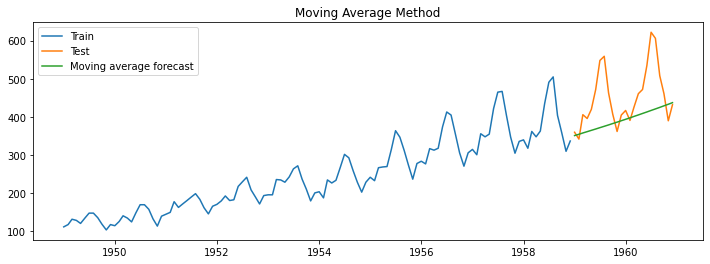

In [52]:
plt.figure(figsize=(12,4))
plt.plot(data['Passengers'][:train_len], label='Train')
plt.plot(data['Passengers'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [53]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ma['ma_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.86,6.72
0,Holt Winters' multiplicative method,32.46,6.45
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39


## Auto regression moving average method (ARMA)

In [54]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.009624
ar.L1.y   -0.527115
ma.L1.y    0.798281
dtype: float64


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Recover original time series

In [55]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

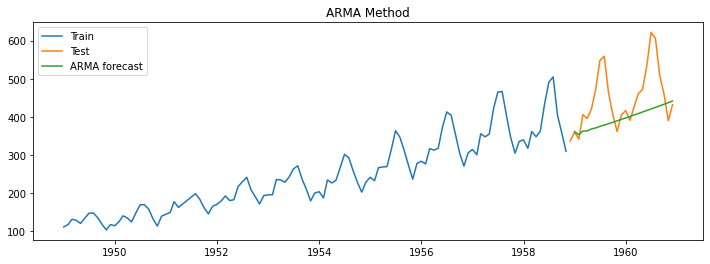

In [56]:
plt.figure(figsize=(12,4))
plt.plot( data['Passengers'][:train_len-1], label='Train')
plt.plot(data['Passengers'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate RMSE and MAPE

In [57]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arma['arma_forecast'][train_len-1:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.86,6.72
0,Holt Winters' multiplicative method,32.46,6.45
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39
0,Autoregressive moving average (ARMA) method,88.88,12.89


## Auto regressive integrated moving average (ARIMA)

In [58]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64


C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Recover original time series forecast

In [59]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

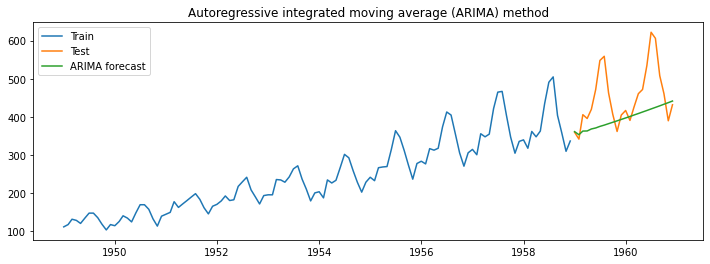

In [60]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [61]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arima['arima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.86,6.72
0,Holt Winters' multiplicative method,32.46,6.45
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39
0,Autoregressive moving average (ARMA) method,88.88,12.89


## Seasonal auto regressive integrated moving average (SARIMA)

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ar.L1       0.388961
ma.L1      -0.680681
ar.S.L12   -0.044838
ma.S.L12   -0.513169
sigma2      0.001408
dtype: float64


### Recover original time series forecast

In [63]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

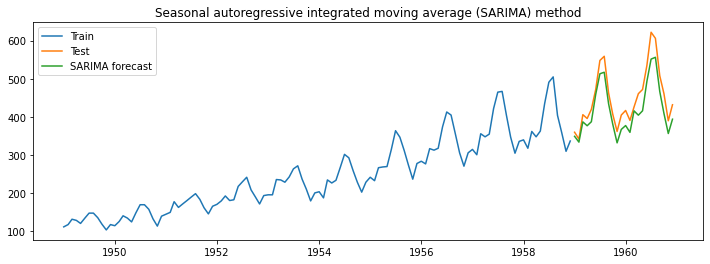

In [64]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [65]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.86,6.72
0,Holt Winters' multiplicative method,32.46,6.45
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39
0,Autoregressive moving average (ARMA) method,88.88,12.89


## Seasonal auto regressive integrate moving average with exogenous variable (SARIMAX)

### Import promotion data

In [66]:
promo = pd.read_csv('../data/promotion.csv', header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


### Split promotion data into train and test data sets

In [67]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

### Build SARIMAX model

In [68]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=promo_train) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ritik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Event       0.034365
ar.L1       0.479088
ma.L1      -0.741942
ar.S.L12   -0.064379
ma.S.L12   -0.557683
sigma2      0.001334
dtype: float64


### Recover original time series forecast

In [69]:
y_hat_sarimax = data_boxcox_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max(), exog=promo_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

### Plot train, test and forecast

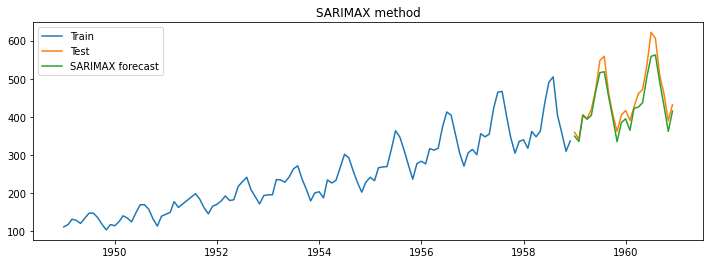

In [70]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX method')
plt.show()

### Calculate RMSE and MAPE

In [71]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,71.94,11.11
0,Holt Winters' additive method,35.86,6.72
0,Holt Winters' multiplicative method,32.46,6.45
0,Autoregressive (AR) method,93.39,13.77
0,Moving Average (MA) method,91.21,13.39
0,Autoregressive moving average (ARMA) method,88.88,12.89
